# Define Dataset and DatasetLoader

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
import  copy
import pandas as pd
class WeaMosDataset(Dataset):
  def __init__(self,file_path):
    self.data=pd.read_csv(file_path)
    featureNames=[]
    for i in range(1,13):
      featureNames.append(f'min_{i}')
      featureNames.append(f'max_{i}')
    self.x=torch.tensor(self.data[featureNames].values,dtype=torch.float32)
    # the species we are studying is Funestus
    # 1 means occurrence, and 0 means non-occurrence
    self.y=torch.tensor(self.data['Funestus'].values,dtype=torch.float32).unsqueeze(-1)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self,idx):
    return self.x[idx], self.y[idx]

train_data=WeaMosDataset('data_ERA5/train_data.csv')
test_data=WeaMosDataset('data_ERA5/test_data.csv')
train_dataLoader=DataLoader(train_data,batch_size=512,shuffle=True)
test_dataLoader=DataLoader(test_data,batch_size=64,shuffle=True)


# Define Network

In [4]:
device=torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
class Net(nn.Module):
  def __init__(self,input_len):
    super(Net,self).__init__()
    self.network=nn.Sequential(
        nn.Linear(input_len,64),
        nn.ReLU(),
        nn.Linear(64,128),
        nn.ReLU(),
        nn.Linear(128,1),
        nn.Sigmoid()
    )
  def forward(self,x):
    predict=self.network(x)
    return predict

In [8]:

def train_loop(dataLoader,model,loss_fn,optimizer):
    model.train()
    for X,Y in dataLoader:
        X=X.to(device)
        Y=Y.to(device)
        pred=model(X)
        loss=loss_fn(pred,Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(dataLoader,model,loss_fn):
    model.eval()
    test_loss=0
    num_correct=0
    num_samples=0
    with torch.no_grad():
    for X,Y in dataLoader:
        X=X.to(device)
        Y=Y.to(device)
        num_samples+=len(Y)
        pred=model(X)
        test_loss+=loss_fn(pred,Y).item()
        num_correct+=sum((pred>0.7)==Y).item()
  # print(f'acc: {num_correct}/{num_samples}')
  return test_loss, num_correct/num_samples



# Importrant note
There are mutiple datasets for requesting history climate data. The datasets we have used are __ERA5__ and __IBM Cleaned Historical Observations__. We prefer the later one since it is cleaned. However, we only have a trial key, and there is a limit on amounts of requests. Hence, we train our model using the data from __IBM Cleaned Historical Observations__ first, and then using __ERA5__ 

Here we set _num\_epoches_ to only 1000. We have trained our model to get accuracy higher than 0.8 by increasing num_epoches. However, when we applied the model with high accuracy to future climate data we got very unreasonable result. We need to do more investigation here in the future.

In [30]:
import numpy as np
learning_rates=[0.0001]
num_epoches=1000
loss_fn=nn.BCELoss()
model=Net(input_len=24)
best_model_wts_acc=copy.deepcopy(model.state_dict())
best_model_wts_loss=copy.deepcopy(model.state_dict())
best_loss=np.inf

for lr in learning_rates:
    print(f'learning rate: {lr}')
    learning_rate=lr
    model=Net(input_len=24)
    model=model.to(device)
    model.load_state_dict(torch.load('models/model_weights.pth'))
    optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)
    for i in range(num_epoches):
        train_loop(train_dataLoader,model,loss_fn,optimizer)
        test_loss,acc=test_loop(test_dataLoader,model,loss_fn)
        if test_loss<best_loss:
            best_loss=test_loss
            best_model_wts_loss=copy.deepcopy(model.state_dict())

        if i%100==0:
    #       print(f'epoch {i}')
          print(f'epoch: {i}|loss:{test_loss}| best loss{best_loss} ')

print('finish')
#save the best model
torch.save(model,'models/model.pth')
model.load_state_dict(best_model_wts_loss)
torch.save(model,'models/model_loss.pth')

learning rate: 0.0001
epoch: 0|loss:9.120170056819916| best loss9.120170056819916 
epoch: 100|loss:8.744555592536926| best loss8.257828056812286 
epoch: 200|loss:8.277874529361725| best loss8.173099279403687 
epoch: 300|loss:8.078656435012817| best loss7.99251314997673 
epoch: 400|loss:8.053171396255493| best loss7.908143520355225 
epoch: 500|loss:7.9585447907447815| best loss7.908143520355225 
epoch: 600|loss:8.04340922832489| best loss7.856935888528824 
epoch: 700|loss:7.880036324262619| best loss7.762709051370621 
epoch: 800|loss:8.305833458900452| best loss7.762709051370621 
epoch: 900|loss:8.170883595943451| best loss7.762709051370621 
finish


# Apply the network to future climate data and visualize the result

In [10]:
import rasterio
import rasterio.features
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors, cm
def plot(img):
    fig=plt.figure(figsize=(10.24,7.68))
    ax=fig.add_subplot(111)
    data=img.read(1,masked=True)
    # fig, ax = plt.subplots()
    # fig.set_size_inches(18.5,10.5)
    show(data, transform=img.transform, ax=ax).grid(True)
    # ax.set_yticks(np.arange(-10, 71, 20))
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=np.nanmin(data), vmax=np.nanmax(data))), ax=ax)
    plt.show()

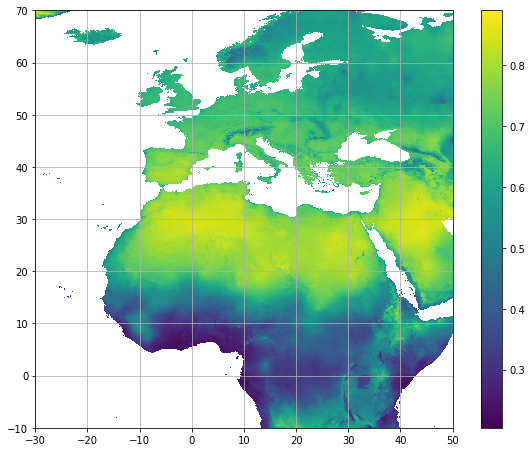

In [31]:
# future climate data from WorldClim https://worldclim.org/data/cmip6/cmip6_clim2.5m.html

tmin = 'future_climate/tmin_eu.tif'
tmax='future_climate/tmax_eu.tif'
# fp=rasterio.open(fp)
tmin=rasterio.open(tmin)
tmax=rasterio.open(tmax)

# construct a features tensor from tif
def tifToFeatures(tmin,tmax):
    n_rows,n_cols=tmin.shape
    temp_tensor=torch.empty(24,n_rows,n_cols,dtype=torch.float32)
    for month in range(12):
        temp_tensor[month]=torch.from_numpy(tmin.read(month+1,masked=False))
    for month in range(12):
        temp_tensor[month+12]=torch.from_numpy(tmax.read(month+1,masked=False))
    return temp_tensor.permute(1,2,0)
temp_tensor=tifToFeatures(tmin,tmax)


model=torch.load('models/model.pth')
pred=np.zeros((temp_tensor.shape[0],temp_tensor.shape[1]))
with torch.no_grad():
    for i in range(pred.shape[0]):
        pred[i]=model(temp_tensor[i].to(device)).cpu().numpy().squeeze()

profile=tmin.profile
profile.update(count=1)
with rasterio.open('future_climate/predict.tif', 'w', **profile) as dst:
    dst.write(pred, 1)
    
img=rasterio.open('future_climate/predict.tif')
plot(img)
img.close()
tmax.close()
tmin.close()